## Imports


In [ ]:
import copy
import logging
import os
from pathlib import Path
from typing import Any, Dict, List, Optional

import open_clip
import wandb

import hydra
import omegaconf
import pytorch_lightning as pl
import torch
from hydra import compose, initialize
from hydra.utils import instantiate
from lightning.pytorch import Callback
from omegaconf import DictConfig, ListConfig, OmegaConf
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from nn_core.callbacks import NNTemplateCore
from nn_core.common import PROJECT_ROOT
from nn_core.common.utils import enforce_tags, seed_index_everything
from nn_core.model_logging import NNLogger
from nn_core.serialization import NNCheckpointIO

# Force the execution of __init__.py if this file is executed directly.
from import mass  # noqa
from mass.data.datasets.registry import get_dataset
from mass.modules.encoder import ClassificationHead, ImageEncoder
from mass.modules.projection_router import ProjectionRouter
from mass.modules.nn_router import NNRouter
from mass.modules.heads import get_classification_head
from mass.modules.router import AbstractRouter
from mass.utils.io_utils import load_model_from_disk
from mass.utils.plots import plot_interactive_radar_chart
from mass.utils.utils import (
    compute_task_dict,
    apply_dict_to_model,
    build_callbacks,
    get_finetuning_accuracies,
    add_normalized_accuracy,
    compute_avg_accuracy,
    print_memory,
    get_routing_weights,
    svd_key_from_layer
)
from mass.task_vectors.task_singular_vectors import *
import json
import logging 

import matplotlib.pyplot as plt
import os

pylogger = logging.getLogger(__name__)

torch.set_float32_matmul_precision("high")

/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-07 12:23:45 INFO     PyTorch version 2.0.1 available.                                           ]8;id=744427;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/datasets/config.py\datasets]8;;\:]8;id=705404;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/datasets/config.py#54\54]8;;\

In [2]:
logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)
logging.getLogger("torch").setLevel(logging.WARNING)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def boilerplate(cfg):
    cfg.core.tags = enforce_tags(cfg.core.get("tags", None))

    num_tasks = len(cfg.eval_datasets)
    cfg.core.tags.append(f"n{num_tasks}")
    cfg.core.tags.append(f'{cfg.nn.module.encoder.model_name}')
    cfg.core.tags.append(f'cifars_notebook')

    template_core = NNTemplateCore(
        restore_cfg=cfg.train.get("restore", None),
    )
    logger: NNLogger = NNLogger(
        logging_cfg=cfg.train.logging, cfg=cfg, resume_id=template_core.resume_id
    )

    logger.upload_source()

    return logger, template_core


In [5]:
import hydra
from hydra import initialize, compose
from typing import Dict, List

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path=str("../conf"), job_name="debug_mnists")
cfg = compose(config_name="task_vectors", overrides=["nn/benchmark=mnists"])

/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py:129: UserWarning: 
'hydra/launcher/submitit_slurm' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
  coro.send(None)


In [ ]:
seed_index_everything(cfg)

logger, template_core = boilerplate(cfg)

Global seed set to 1608637542


2025-03-07 12:24:06 INFO     Setting seed 1608637542 from seeds[0]                         ]8;id=506654;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py\nn_core.common.utils]8;;\:]8;id=125355;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py#107\107]8;;\

                    INFO     Tags: ['no_redundancy_tasks']                                  ]8;id=507214;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py\nn_core.common.utils]8;;\:]8;id=552910;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py#96\96]8;;\

                    INFO     Restoring with mode: <None>                                         ]8;id=346224;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/resume.py\nn_core.resume]8;;\:]8;id=130475;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/resume.py#122\122]8;;\

                    INFO     Instantiating <WandbLogger>                                   ]8;id=170108;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py\nn_core.model_logging]8;;\:]8;id=507338;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py#41\41]8;;\

                    ERROR    Failed to detect the name of this notebook, you can set it manually  ]8;id=25814;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/wandb/jupyter.py\wandb.jupyter]8;;\:]8;id=720665;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/wandb/jupyter.py#224\224]8;;\
                             with the WANDB_NOTEBOOK_NAME environment variable to enable code                      
                             saving.                                                                               

wandb: Currently logged in as: crisostomi (gladia). Use `wandb login --relogin` to force relogin


2025-03-07 12:24:08 INFO     Uploading source code to W&B                                  ]8;id=591644;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py\nn_core.model_logging]8;;\:]8;id=663784;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py#63\63]8;;\

In [7]:
# only has vision encoder, no text transformer
zeroshot_encoder_statedict = load_model_from_disk(cfg.misc.pretrained_checkpoint)

zeroshot_encoder: ImageEncoder = instantiate(
    cfg.nn.module.encoder
)  # the second pass backbone

2025-03-07 12:24:56 INFO     Loading ViT-B-32 pre-trained weights.                           ]8;id=560796;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py\tvp.modules.encoder]8;;\:]8;id=355368;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py#17\17]8;;\

                    INFO     Loading pretrained ViT-B-32 from OpenAI.                                       ]8;id=234146;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/open_clip/factory.py\root]8;;\:]8;id=188054;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/open_clip/factory.py#82\82]8;;\

2025-03-07 12:24:57 INFO     Removing text transformer from the model.                       ]8;id=303714;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py\tvp.modules.encoder]8;;\:]8;id=944046;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py#31\31]8;;\

### Visualize some images from CIFAR10, STL10 and CIFAR100

In [8]:
datasets_to_visualize = ['Cars', 'DTD', 'EuroSAT', 'MNIST']

datasets = {
    dataset: get_dataset(
        dataset,
        preprocess_fn=zeroshot_encoder.val_preprocess,
        location=cfg.nn.data.data_path,
        batch_size=cfg.nn.data.batch_size.train,
    )
    for dataset in datasets_to_visualize
}


Visualizing random Cars validation samples:


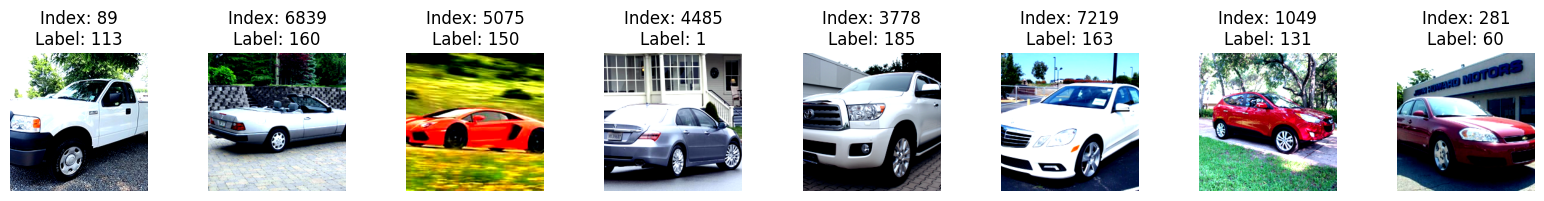

Visualizing random DTD validation samples:


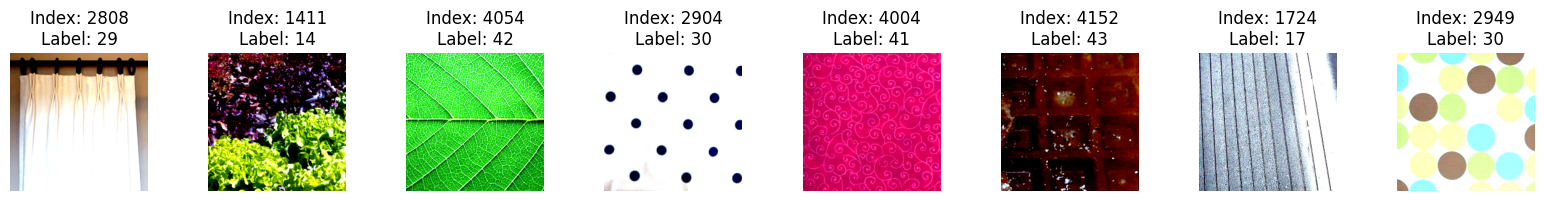

Visualizing random EuroSAT validation samples:


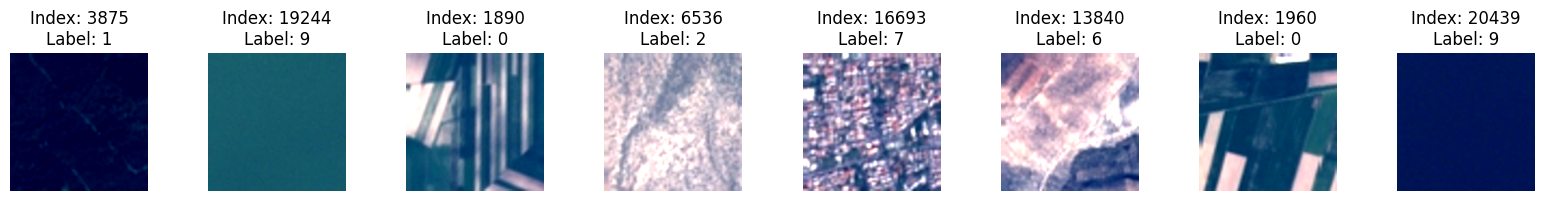

Visualizing random MNIST validation samples:


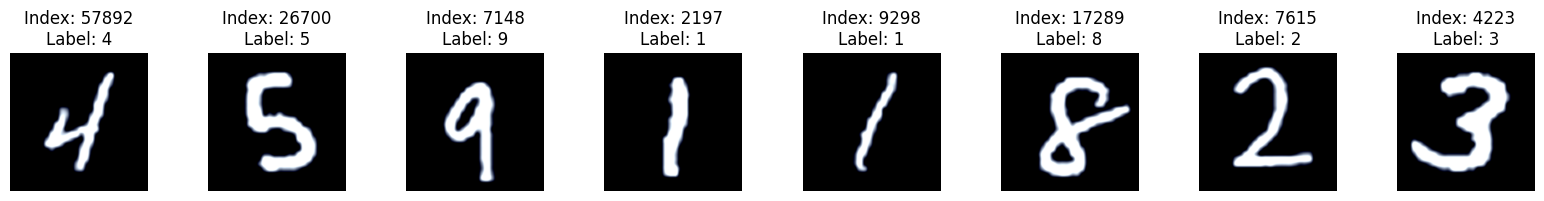

In [ ]:
def visualize_random_samples(dataset, n_samples=8):
    """
    Shows a grid of n_samples random images (and their labels/indices) from a dataset.
    Assumes each dataset item is (image, label).
    """
    indices = np.random.choice(len(dataset), size=n_samples, replace=False)
    
    fig, axes = plt.subplots(1, n_samples, figsize=(2 * n_samples, 2))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]  # image shape [C, H, W]

        # Convert tensor -> NumPy and move channels last: [C, H, W] -> [H, W, C]
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Rescale from [-1, 1] to [0, 1]
        image_np = (image_np + 1) / 2.0
        image_np = np.clip(image_np, 0, 1)

        axes[i].imshow(image_np, cmap="gray")
        axes[i].set_title(f"Index: {idx}\nLabel: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


for dataset_name, dataset in datasets.items():
    print(f"Visualizing random {dataset_name} validation samples:")
    visualize_random_samples(dataset.train_dataset, n_samples=8)




In [39]:
idxs = {'cars': [437, 5048, 5075], 'dtd': [1847, 699, 3179], 'eurosat': [221, 1873, 2359], 'mnist': [31484, 40266, 20594]}

FileNotFoundError: [Errno 2] No such file or directory: '../plots/Cars_437.png'

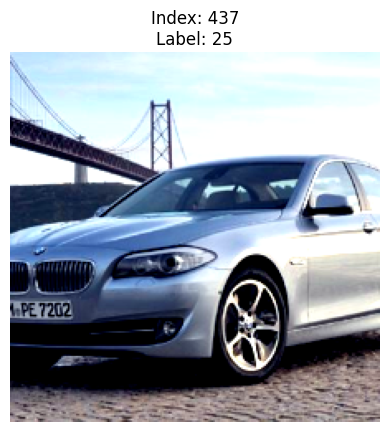

In [ ]:
# plot and save each idx

for dataset_name, dataset in datasets.items():

    for num, idx in enumerate(idxs[dataset_name.lower()]):
        image, label = dataset.train_dataset[idx]
        image_np = (image.permute(1, 2, 0).cpu().numpy() + 1) / 2.0
        image_np = np.clip(image_np, 0, 1)
        plt.imshow(image_np, cmap="gray")
        plt.axis("off")
        plt.title(f"Index: {idx}\nLabel: {label}")
        plt.savefig(f"../figures/{dataset_name}_{num}.png")
        plt.show